# Homework 05

In [1]:
import numpy as np
import pandas as pd
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import urllib.request
from io import StringIO
import sklearn
import sklearn.cluster
from sklearn import metrics
from skimage import measure
import cv2
import keras
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential

Populating the interactive namespace from numpy and matplotlib


## Image Segmentation

In [2]:
def plot_image_with_patches(img, patches):
  fig, (ax1) = plt.subplots(1,figsize=(10,10))
  plt.xticks([]),plt.yticks([])
  ax1.imshow(img);

  for patch in patches:
    rectBorder = matplotlib.patches.Rectangle(patch[0], patch[1], patch[2], edgecolor="red", linewidth=2, fill=False)
    ax1.add_patch(rectBorder)

  plt.show()

In [3]:
def find_image_matching_patches(img_patches, img_res):
  matching_patches = []

  for p in img_patches:
    p_width = p.bbox[3] - p.bbox[1]
    p_height = p.bbox[2] - p.bbox[0]
    aspect_ratio = p_width / p_height

    # Check for Patch Area
    if p.area > 0.5 * img_res.shape[0] * img_res.shape[1] or p.area < 0.001 * img_res.shape[0] * img_res.shape[1]:
     continue

    matching_patches.append([(p.bbox[1], p.bbox[0]), p_width, p_height])

  return matching_patches

NEXT IMAGE...


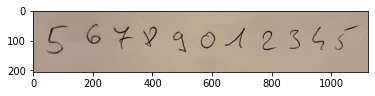

Image Patch Count:  16
Image Matching Patch Count:  12


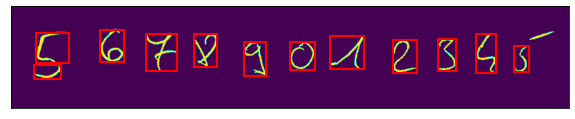


NEXT IMAGE...


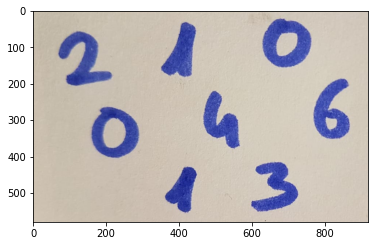

Image Patch Count:  9
Image Matching Patch Count:  8


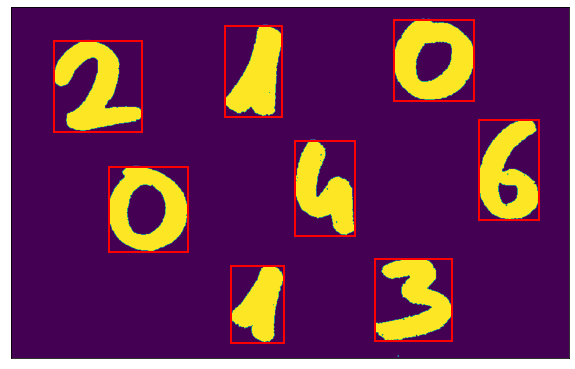


NEXT IMAGE...


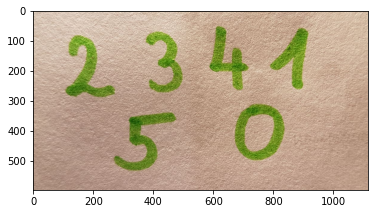

Image Patch Count:  2441
Image Matching Patch Count:  6


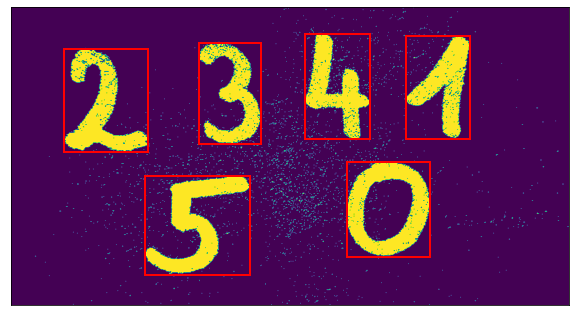


NEXT IMAGE...


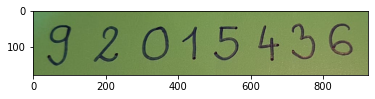

Image Patch Count:  15
Image Matching Patch Count:  8


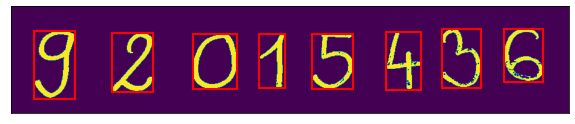


NEXT IMAGE...


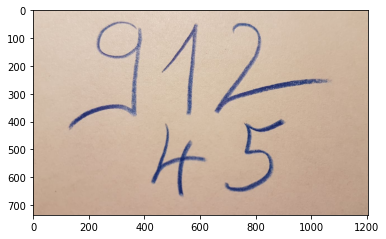

Image Patch Count:  125
Image Matching Patch Count:  6


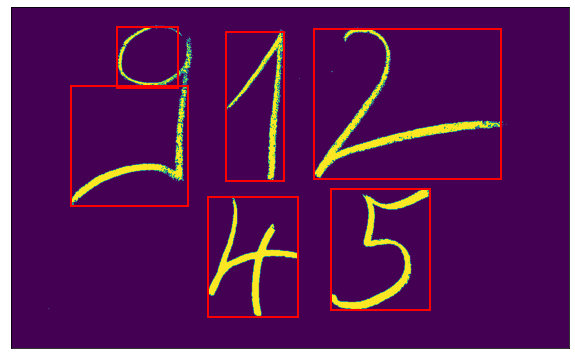


NEXT IMAGE...


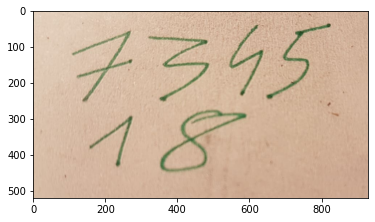

Image Patch Count:  40
Image Matching Patch Count:  7


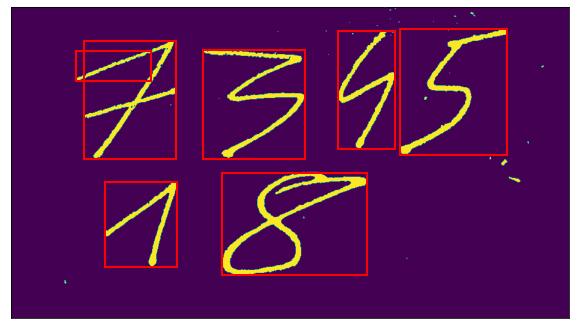


NEXT IMAGE...


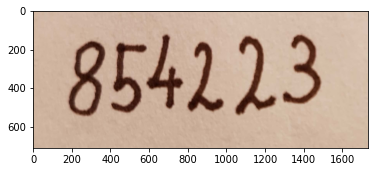

Image Patch Count:  6
Image Matching Patch Count:  6


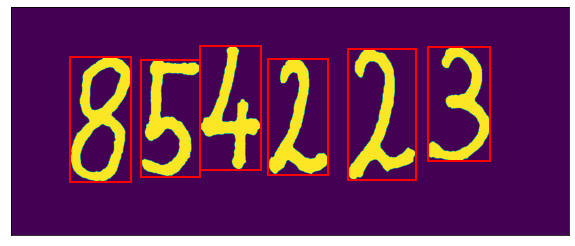


NEXT IMAGE...


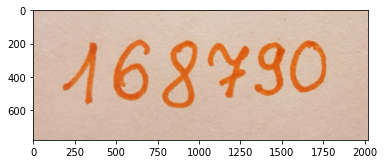

Image Patch Count:  7
Image Matching Patch Count:  6


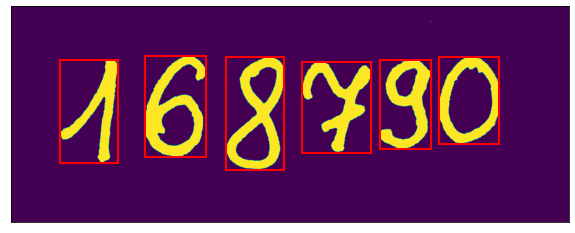


NEXT IMAGE...


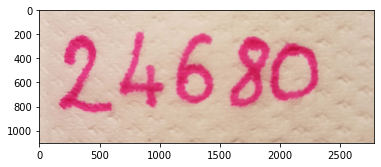

Image Patch Count:  16
Image Matching Patch Count:  5


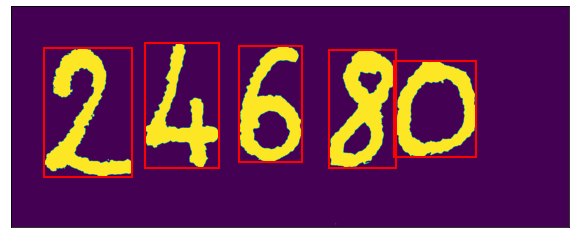


NEXT IMAGE...


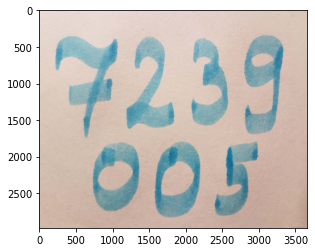

Image Patch Count:  310
Image Matching Patch Count:  7


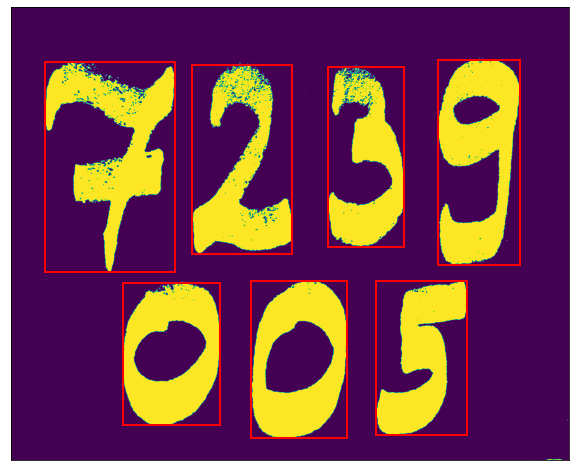


NEXT IMAGE...


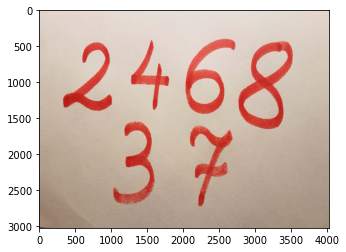

Image Patch Count:  883
Image Matching Patch Count:  7


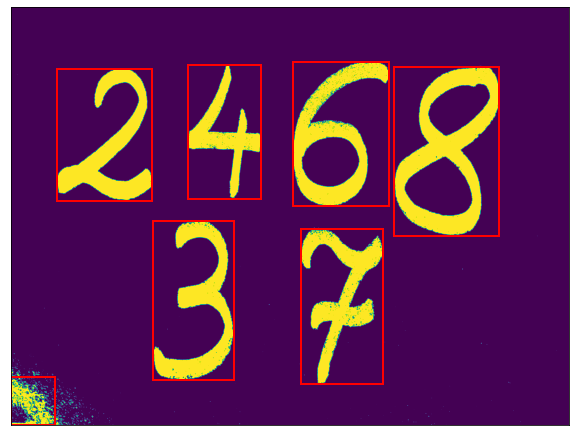


NEXT IMAGE...


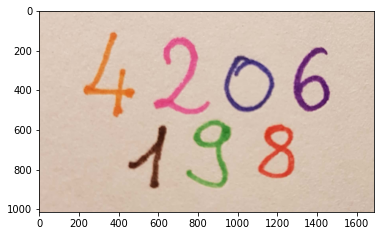

Image Patch Count:  10
Image Matching Patch Count:  7


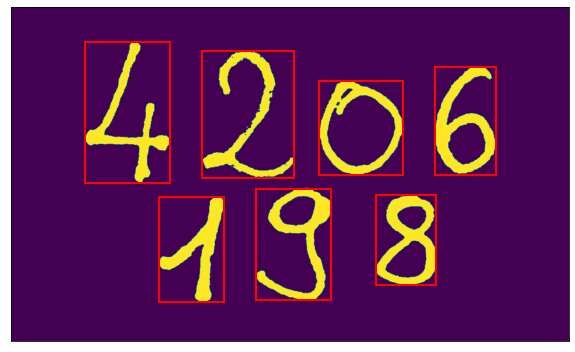

In [83]:
files = ["1.png", "2.png", "3.png", "4.png", "5.png", "6.png", 
         "7.png", "8.png", "9.png", "10.png", "11.png", "12.png"]

images = []

for f in files:
  print("NEXT IMAGE...")

  # Get Image
  img = mpimg.imread(f)
  imgplot = plt.imshow(img)
  plt.show()

  # K-Means Clustering
  img_shape = (img.shape[0], img.shape[1])
  rgba = img.reshape((-1,4))
  kmeans = sklearn.cluster.KMeans(n_clusters = 2).fit(rgba)

  pred = kmeans.predict(rgba)
  pred = pred if pred[0] == 0 else abs(1-pred)
  res = pred.reshape(img_shape)

  regions = measure.label(res, connectivity = 1, background = 0)
  patches = measure.regionprops(regions)

  print('Image Patch Count: ', len(patches))

  matching_patches = find_image_matching_patches(patches, res)

  print('Image Matching Patch Count: ', len(matching_patches))

  plot_image_with_patches(res, matching_patches)

  img_numbers = []

  for p in matching_patches:
    (x, y), w, h = p
    img_numbers.append(res[y:y+h,x:x+w])

  images.append(img_numbers)

  print()

Next Image


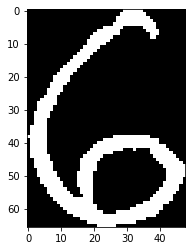

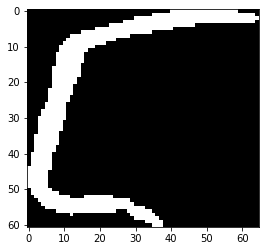

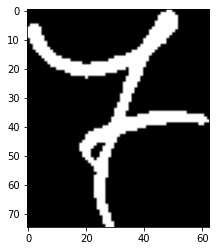

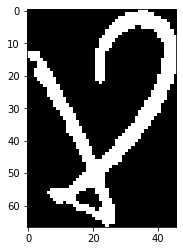

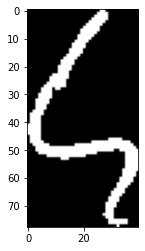

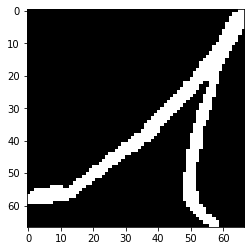

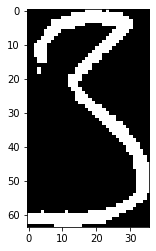

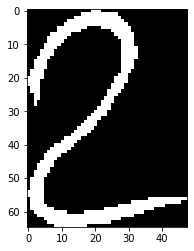

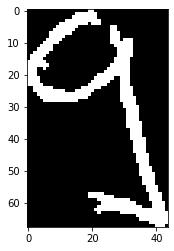

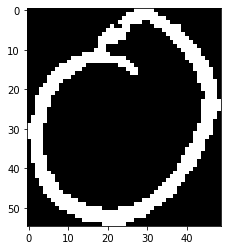

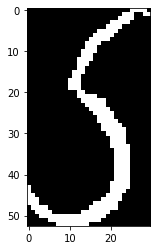

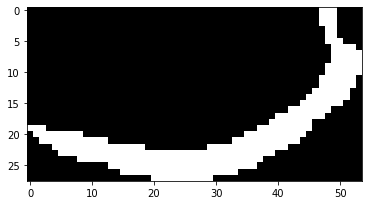

Next Image


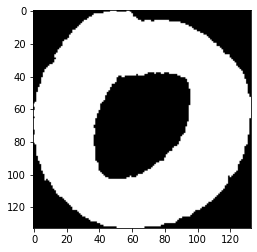

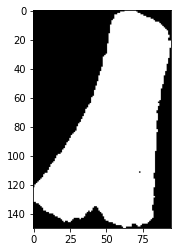

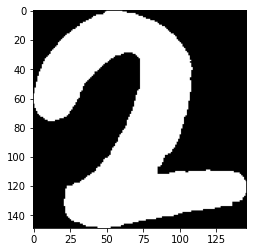

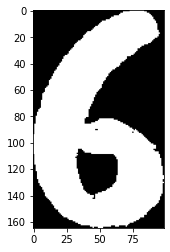

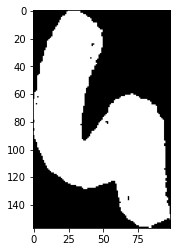

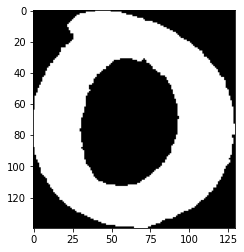

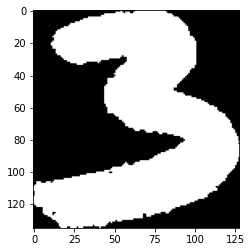

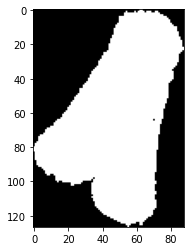

Next Image


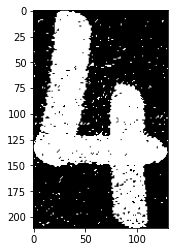

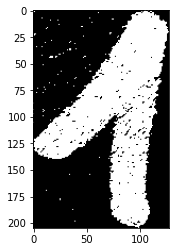

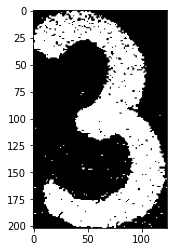

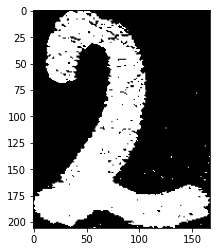

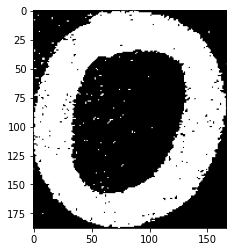

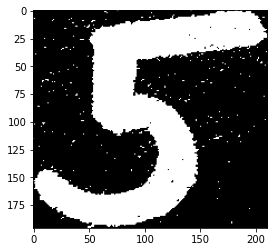

Next Image


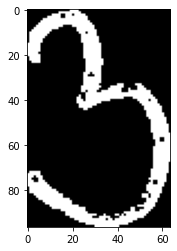

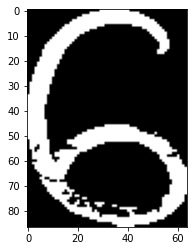

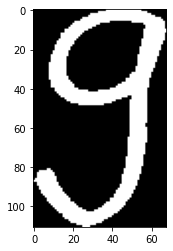

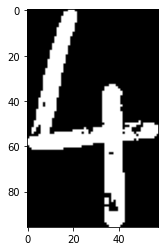

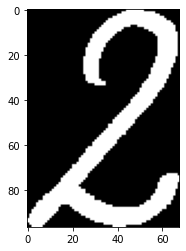

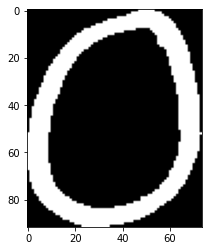

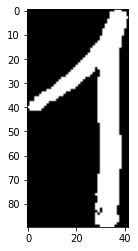

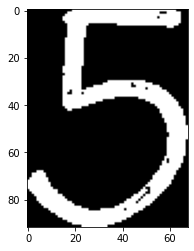

Next Image


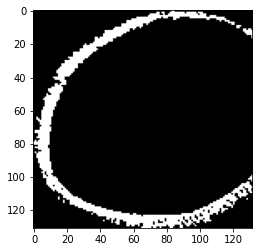

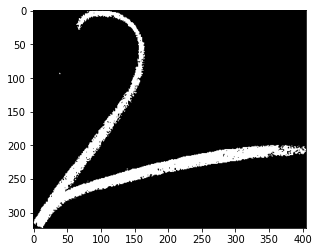

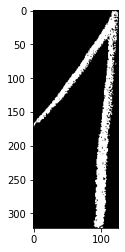

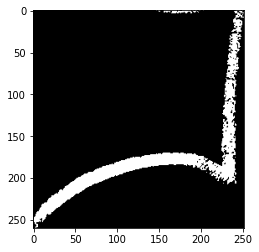

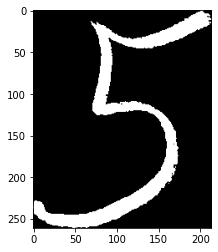

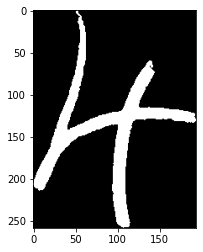

Next Image


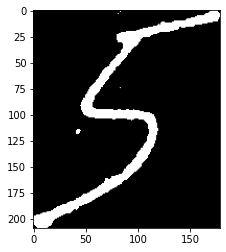

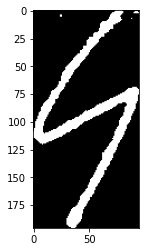

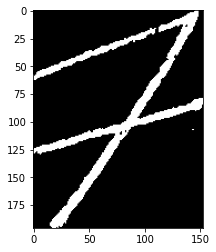

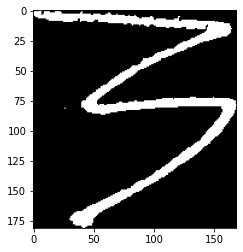

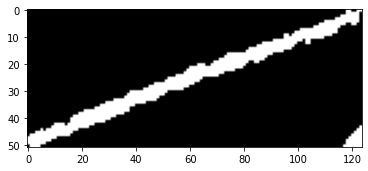

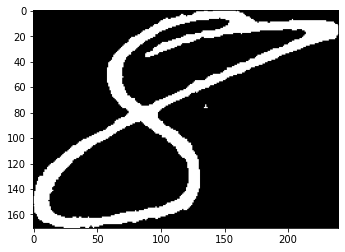

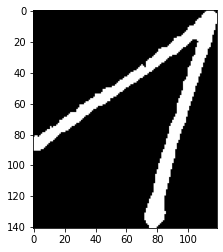

Next Image


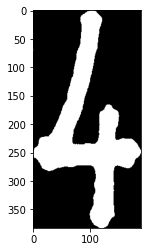

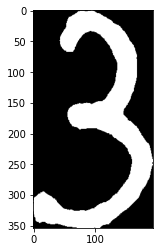

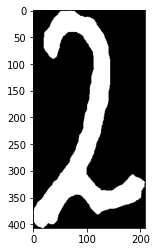

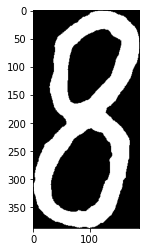

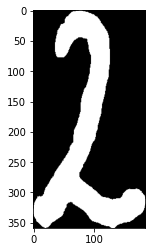

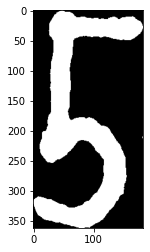

Next Image


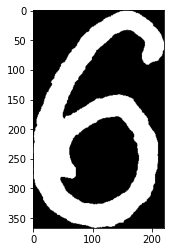

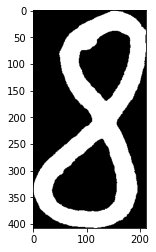

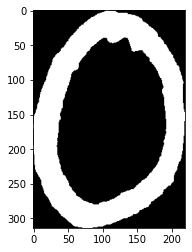

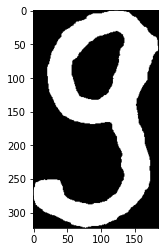

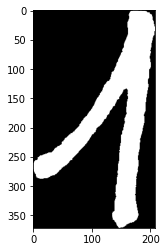

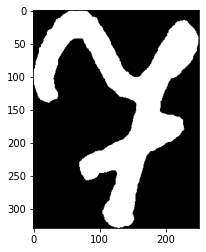

Next Image


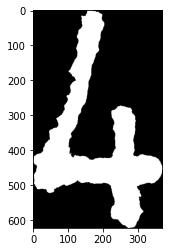

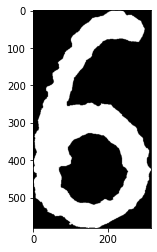

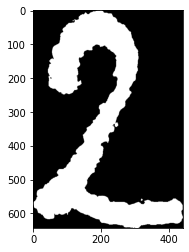

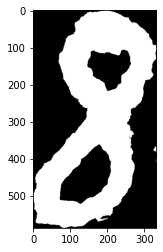

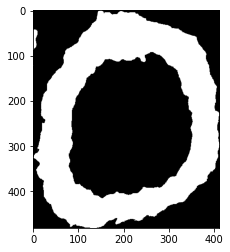

Next Image


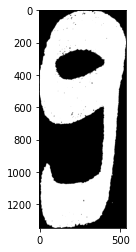

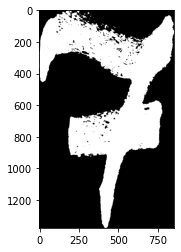

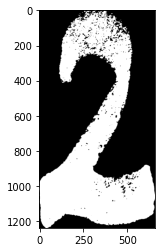

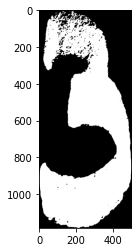

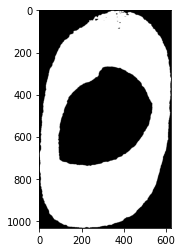

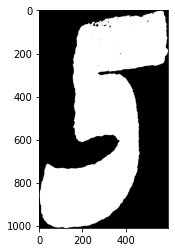

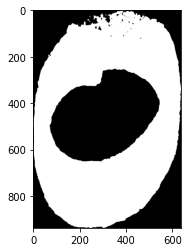

Next Image


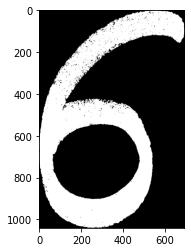

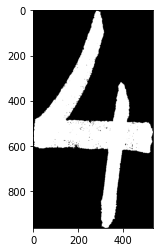

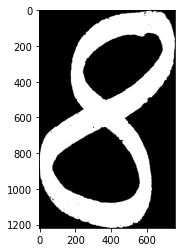

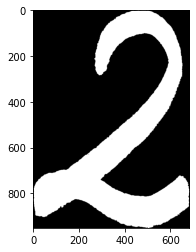

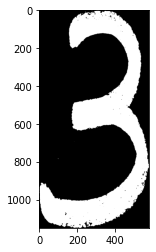

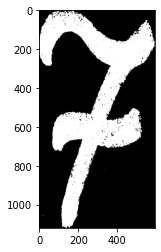

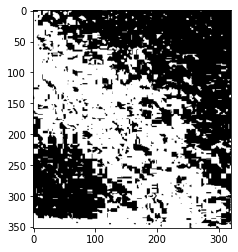

Next Image


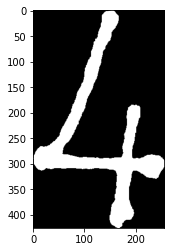

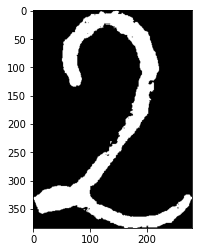

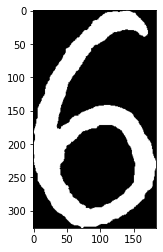

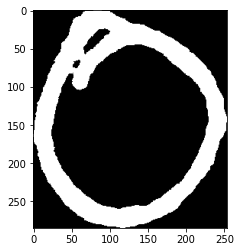

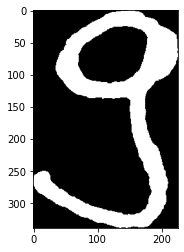

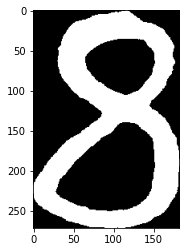

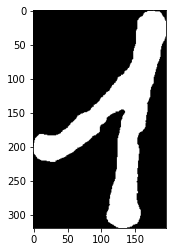

In [84]:
for img in images:
  print("Next Image")
  for number in img:
    imgplot = plt.imshow(number, cmap='gray')
    plt.show()

## Number Transformation

In [85]:
def translate(values, leftMin, leftMax, rightMin, rightMax):
    # Figure out how 'wide' each range is
    leftSpan = leftMax - leftMin
    rightSpan = rightMax - rightMin

    # Convert the left range into a 0-1 range (float)
    valuesScaled = (values - leftMin) / leftSpan

    # Convert the 0-1 range into a value in the right range.
    return rightMin + (valuesScaled * rightSpan)

In [86]:
target_size = (28, 28)

transformed_numbers = []

for i in range(len(images)):
  for j in range(len(images[i])):
    number = np.array(images[i][j] * 255, dtype='uint8')
    (h, w) = number.shape

    # Add border all around the number of 15%
    border = round(min(h, w) * 0.15)
    number = cv2.copyMakeBorder(number, border, border, border, border, cv2.BORDER_CONSTANT, value = 0)

    # Add border until aspect ration becomes 1
    border_y = max(w-h, 0) // 2
    border_x = max(h-w, 0) // 2
    number = cv2.copyMakeBorder(number, border_y, border_y, border_x, border_x, cv2.BORDER_REPLICATE)

    # if number is None:
    #   print(i, j)

    # Resize to the target size
    number = cv2.resize(number, target_size)

    transformed_numbers.append(number)


In [87]:
transformed_numbers = np.array(transformed_numbers)

In [88]:
transformed_numbers.shape

(85, 28, 28)

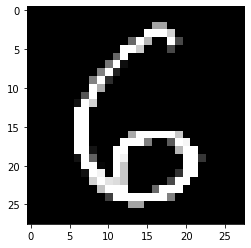

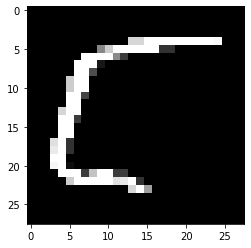

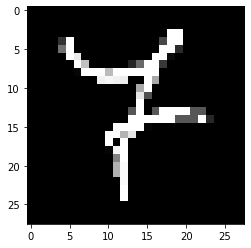

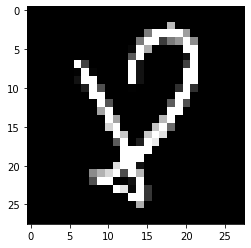

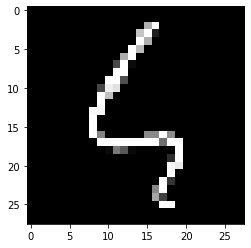

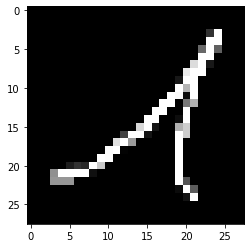

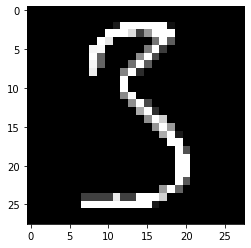

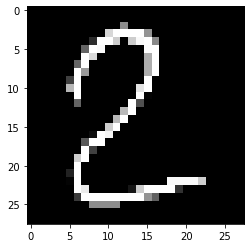

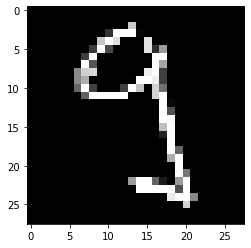

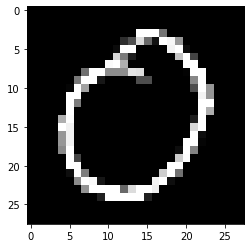

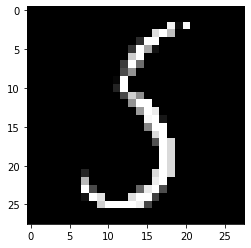

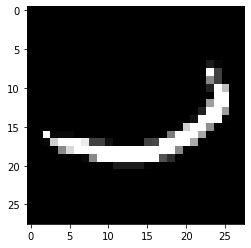

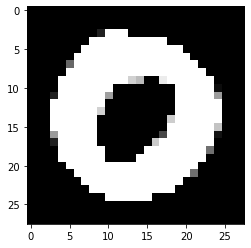

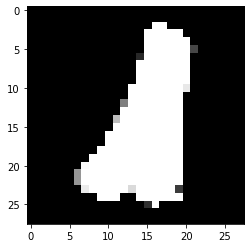

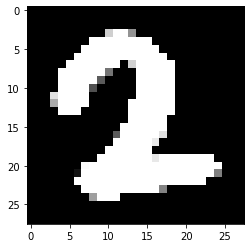

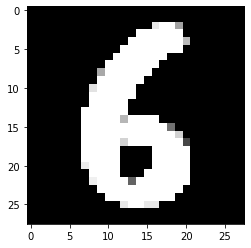

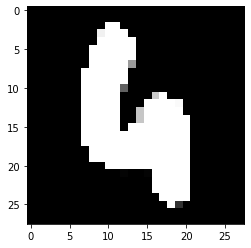

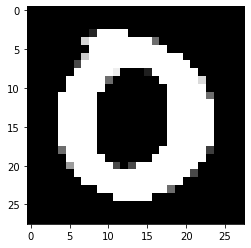

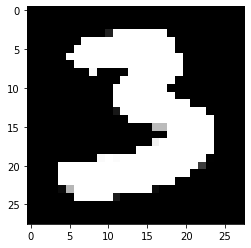

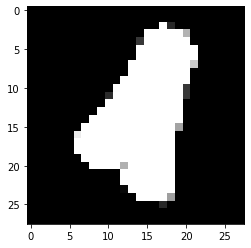

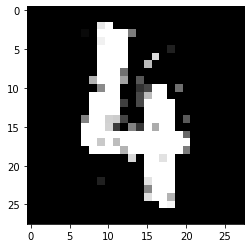

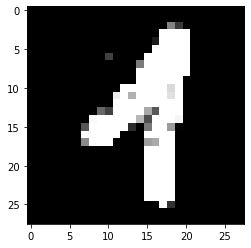

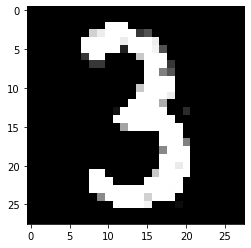

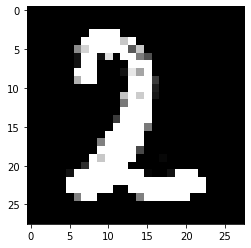

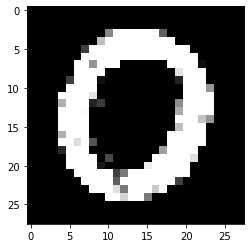

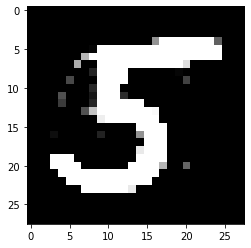

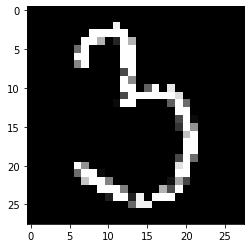

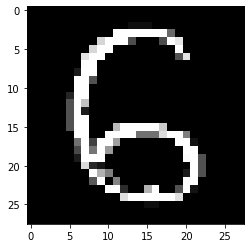

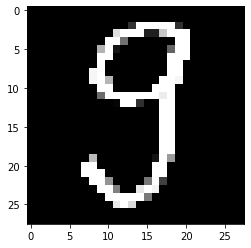

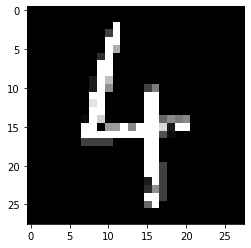

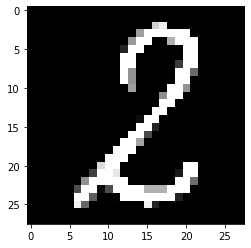

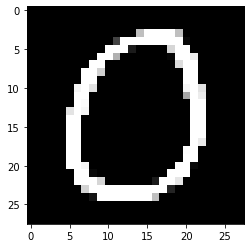

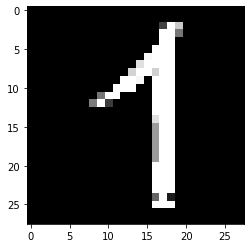

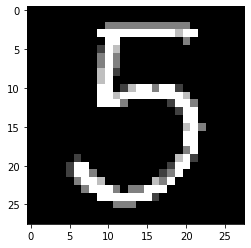

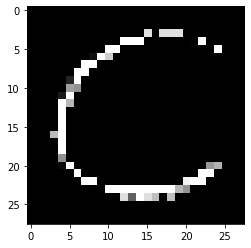

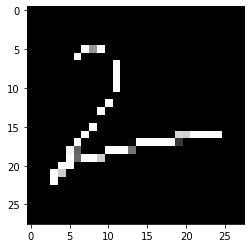

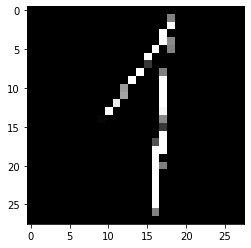

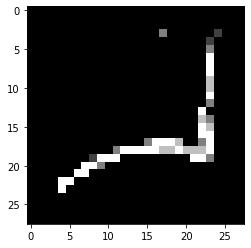

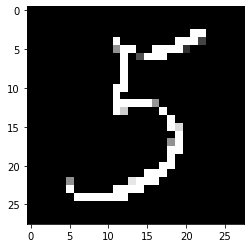

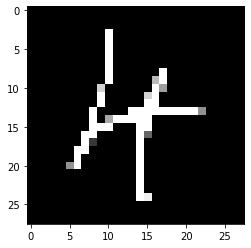

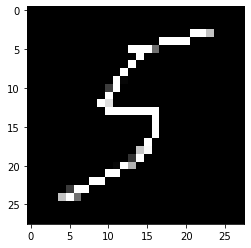

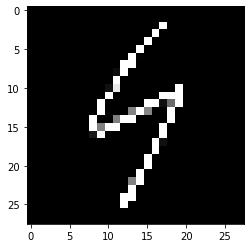

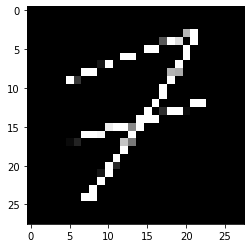

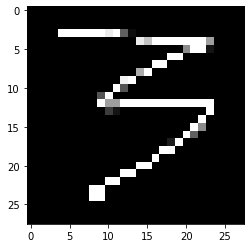

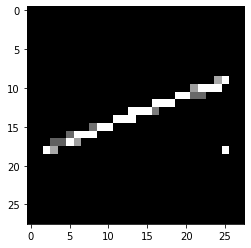

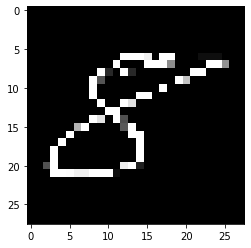

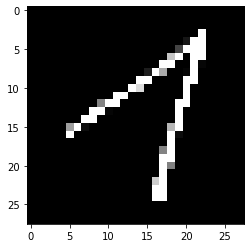

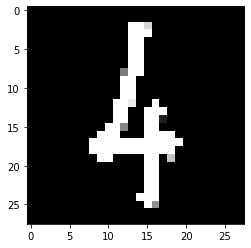

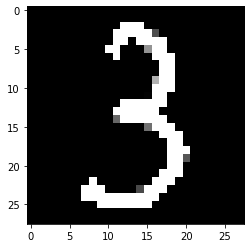

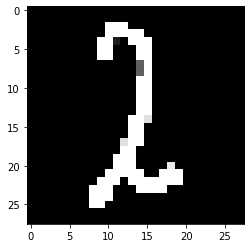

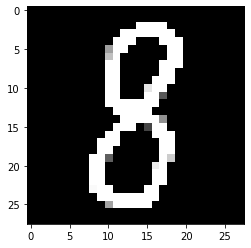

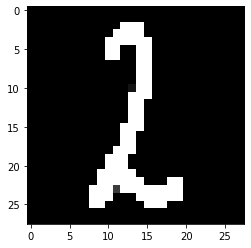

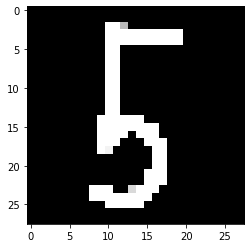

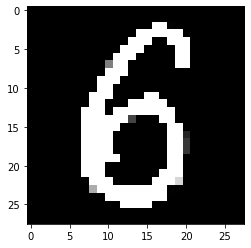

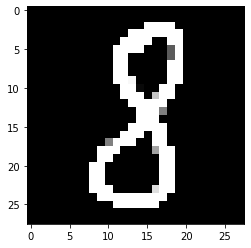

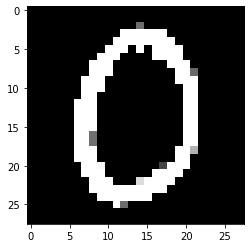

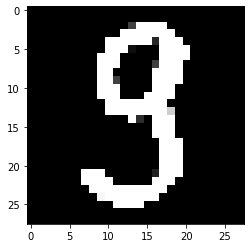

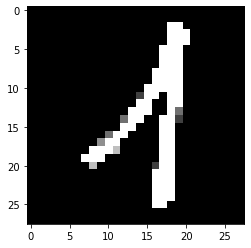

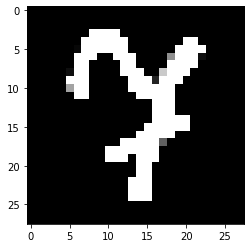

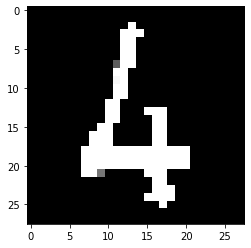

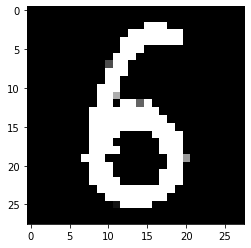

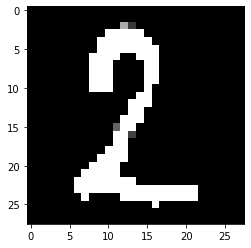

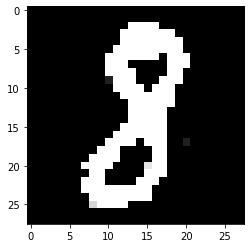

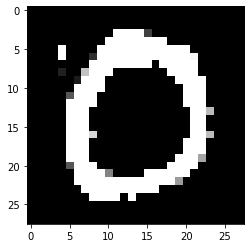

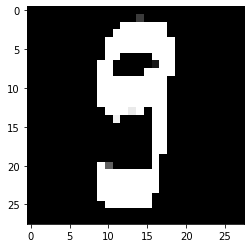

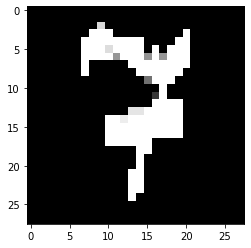

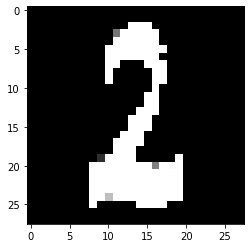

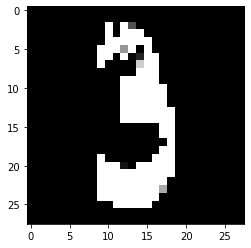

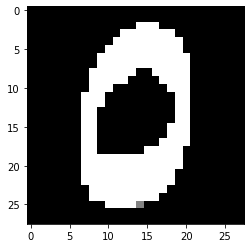

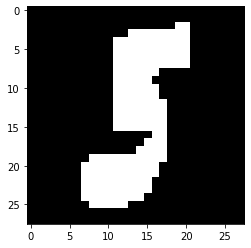

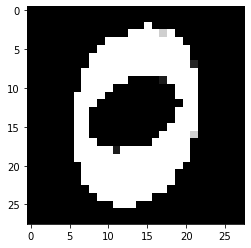

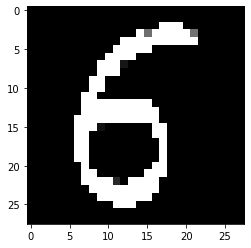

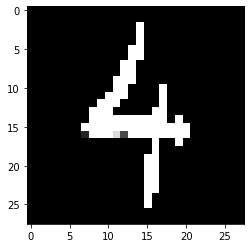

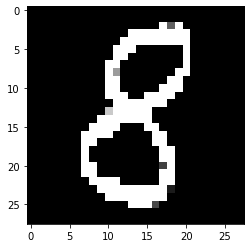

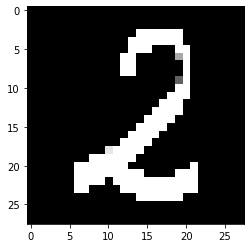

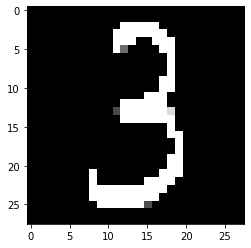

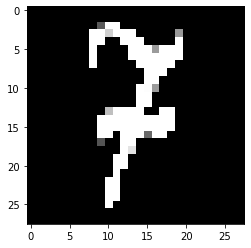

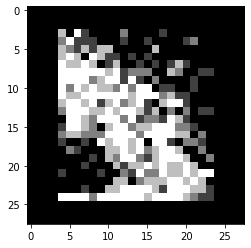

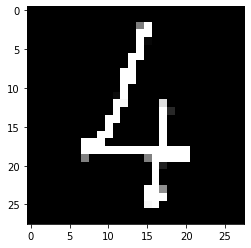

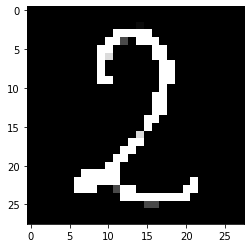

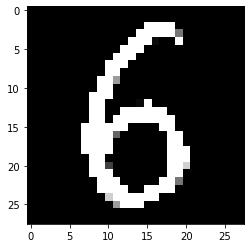

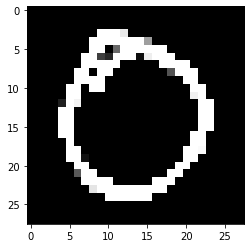

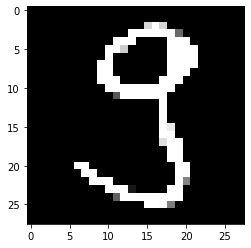

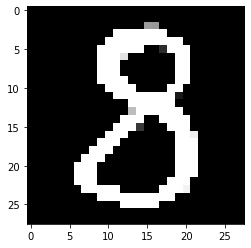

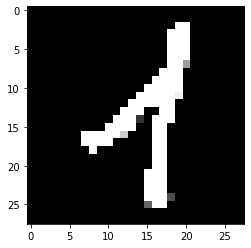

In [89]:
for number in transformed_numbers:
    imgplot = plt.imshow(number, cmap='gray')
    plt.show()

## Neural Network

This neural network is trained using the `mnist` dataset using **keras**.

In [20]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [21]:
len(train_X), len(test_X)

(60000, 10000)

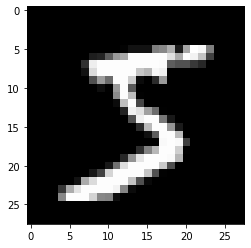

Expected prediciton: 5



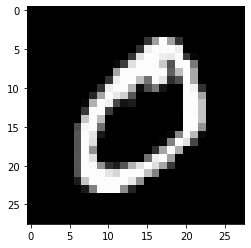

Expected prediciton: 0



In [22]:
for i in range(2):
    plt.imshow(train_X[i],cmap='gray')
    plt.show()
    print("Expected prediciton:", train_y[i])
    print()

In [23]:
train_X = train_X.reshape((60000, -1))
test_X = test_X.reshape((10000, -1))

train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [24]:
new_train_y = np.zeros((60000, 10))

for i in range(len(new_train_y)):
  new_train_y[i][train_y[i]] = 1

train_y = new_train_y

In [25]:
model = Sequential()
model.add(Dense(75, input_shape=(784,), activation='relu'))
model.add(Dense(10, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [26]:
model.fit(train_X, train_y, epochs=10, batch_size=10)

Epoch 1/10
6000/6000 [==============================] - 14s 2ms/step - loss: 0.3410 - accuracy: 0.8730
Epoch 2/10
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0597 - accuracy: 0.9175
Epoch 3/10
6000/6000 [==============================] - 14s 2ms/step - loss: 0.0502 - accuracy: 0.9316
Epoch 4/10
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0472 - accuracy: 0.9368
Epoch 5/10
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0440 - accuracy: 0.9392
Epoch 6/10
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0428 - accuracy: 0.9413
Epoch 7/10
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0418 - accuracy: 0.9413
Epoch 8/10
6000/6000 [==============================] - 12s 2ms/step - loss: 0.0409 - accuracy: 0.9414
Epoch 9/10
6000/6000 [==============================] - 13s 2ms/step - loss: 0.0401 - accuracy: 0.9435
Epoch 10/10
6000/6000 [==============================] - 13s 2ms/step - l

In [27]:
predictions = model.predict(test_X)

313/313 [==============================] - 1s 2ms/step


In [28]:
predictions = predictions.argmax(axis = 1)

In [29]:
cm = metrics.confusion_matrix(predictions, test_y)
print(cm)

[[ 969    0    9    2    4    8   13    0    7    8]
 [   1 1118    0    0    1    0    3    3    6    5]
 [   0    3  951    7    3    2    2   13    4    0]
 [   0    2    8  913    0    9    0    2    3    3]
 [   2    0    1    0  914    1    6    5    7   13]
 [   0    1    1   19    0  806    5    0    4    0]
 [   3    3    5    0    3    8  910    0    3    0]
 [   1    0    5    3    0    1    0  965    1    4]
 [   4    8   50   57   25   49   19   18  931   25]
 [   0    0    2    9   32    8    0   22    8  951]]


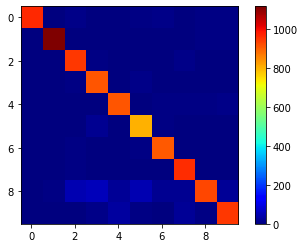

In [30]:
plt.imshow(cm,cmap='jet')
plt.colorbar()

## Test and Evaluation

In [90]:
test_images = transformed_numbers.reshape((len(transformed_numbers), -1))
test_images.shape

(85, 784)

In [91]:
predictions = model.predict(test_images)
predictions = predictions.argmax(axis = 1)

predictions

3/3 [==============================] - 0s 8ms/step


array([8, 5, 7, 8, 8, 1, 5, 3, 8, 0, 5, 6, 0, 8, 2, 5, 8, 0, 3, 8, 4, 8,
       3, 2, 0, 5, 3, 2, 5, 4, 2, 0, 9, 5, 5, 2, 8, 2, 5, 4, 3, 8, 4, 6,
       5, 3, 4, 6, 3, 2, 8, 3, 5, 5, 8, 0, 5, 4, 7, 2, 5, 2, 8, 0, 5, 2,
       5, 3, 8, 5, 8, 5, 4, 8, 2, 3, 2, 8, 8, 2, 8, 0, 3, 8, 4])

In [92]:
test_images_numbers = [
    6, 5, 7, 8, 4, 1, 3, 2, 9, 0, 5, 5,
    0, 1, 2, 6, 4, 0, 3, 1, 
    4, 1, 3, 2, 0, 5, 
    3, 6, 9, 4, 2, 0, 1, 5, 
    9, 2, 1, 9, 5, 4, 
    5, 4, 7, 3, 7, 8, 1,
    4, 3, 2, 8, 2, 5,
    6, 8, 0, 9, 1, 7, 
    4, 6, 2, 8, 0, 
    9, 7, 2, 3, 0, 5, 0, 
    6, 4, 8, 2, 3, 7, 0, 
    4, 2, 6, 0, 9, 8, 1
]

In [94]:
print('Acuracy:', metrics.accuracy_score(test_images_numbers, predictions))

Acuracy: 0.49411764705882355
